Statistique observée (moyenne) : 4.828701438558171


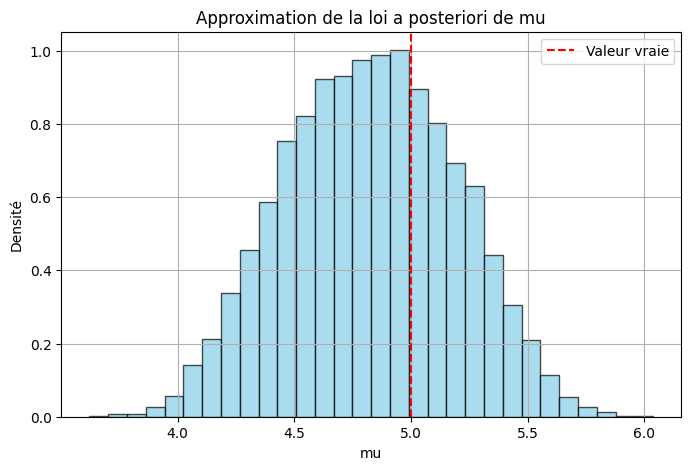

Nombre de paramètres acceptés : 9927 / 100000


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # Seed pour la reproductibilité

mu_true = 5  # Paramètre vrai inconnu

n_obs = 20  # Nombre d'observations
y_obs = np.random.normal(loc=mu_true, scale=1, size=n_obs)  # Données observées

s_obs = np.mean(y_obs)  # Statistique résumée : moyenne des données
print("Statistique observée (moyenne) :", s_obs)

N = 100000  # Nombre d'échantillons proposés
epsilon = 0.5  # Seuil d'acceptation
accepted_thetas = []  # Liste des paramètres acceptés

for _ in range(N):
    theta = np.random.uniform(0, 10)  # Tirage depuis la prior (Uniforme sur [0, 10])
    y_sim = np.random.normal(loc=theta, scale=1, size=n_obs)  # Simulation de données
    s_sim = np.mean(y_sim)  # Statistique résumée simulée

    if abs(s_sim - s_obs) < epsilon:  # Critère d'acceptation
        accepted_thetas.append(theta)

plt.figure(figsize=(8, 5))
plt.hist(accepted_thetas, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(mu_true, color='red', linestyle='--', label='Valeur vraie')
plt.title('Approximation de la loi a posteriori de mu')
plt.xlabel('mu')
plt.ylabel('Densité')
plt.legend()
plt.grid(True)
plt.show()

print(f"Nombre de paramètres acceptés : {len(accepted_thetas)} / {N}")


In [2]:
import numpy as np

def alpha_stable_generator(alpha, beta, sigma=1, mu=0, size=1):
    """
    Simule des variables suivant une loi alpha-stable en utilisant la méthode CMS.
    """
    if alpha <= 0 or alpha > 2:
        raise ValueError("alpha must be in (0, 2]")
    if not -1 <= beta <= 1:
        raise ValueError("beta must be in [-1, 1]")
    
    U = np.pi * (np.random.uniform(low=-0.5, high=0.5, size=size))  # uniforme sur (-pi/2, pi/2)
    W = np.random.exponential(scale=1.0, size=size)  # exponentielle(1)

    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        B = (1 / alpha) * np.arctan(const)
        S = (1 + const**2)**(1 / (2 * alpha))

        part1 = np.sin(alpha * (U + B)) / (np.cos(U))**(1 / alpha)
        part2 = (np.cos(U - alpha * (U + B)) / W)**((1 - alpha) / alpha)
        X = S * part1 * part2
    else:
        # Cas alpha = 1
        part1 = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U)) / (np.pi / 2 + beta * U)))
        X = part1

    return sigma * X + mu


la loi générée a exactement la meme fonction caractéristique qu'une loi alpha stable, cf article sur Chambers-Mallows-Stuck pour voir la démo entière

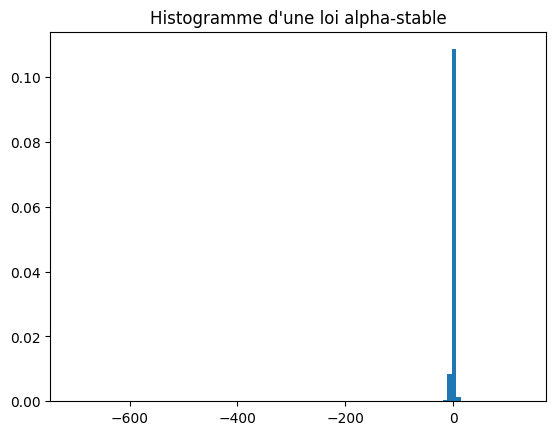

In [8]:
import matplotlib.pyplot as plt

samples = alpha_stable_generator(alpha=1.5, beta=0, size=10000)
plt.hist(samples, bins=100, density=True)
plt.title("Histogramme d'une loi alpha-stable")
plt.show()


In [9]:
def h(y):
    return np.sin(y)

from scipy.stats import qmc

def generate_rqmc_pairs(n):
    sampler = qmc.Sobol(d=2, scramble=True)  # 2D: for U and W
    samples = sampler.random(n)
    
    # Transform into U ~ Uniform(-pi/2, pi/2), W ~ Exp(1)
    U_rqmc = -np.pi/2 + np.pi * samples[:, 0]
    W_rqmc = -np.log(1 - samples[:, 1])  # Inverse transform sampling for Exp(1)
    
    return U_rqmc, W_rqmc

def alpha_stable_from_UW(alpha, beta, U, W, sigma=1, mu=0):
    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        B = (1 / alpha) * np.arctan(const)
        S = (1 + const**2)**(1 / (2 * alpha))

        part1 = np.sin(alpha * (U + B)) / (np.cos(U))**(1 / alpha)
        part2 = (np.cos(U - alpha * (U + B)) / W)**((1 - alpha) / alpha)
        X = S * part1 * part2
    else:
        part1 = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U)) / (np.pi / 2 + beta * U)))
        X = part1

    return sigma * X + mu

def compare_estimators(alpha, beta, sigma, mu, n=10000):
    # Monte Carlo
    Y_mc = alpha_stable_generator(alpha, beta, sigma, mu, size=n)
    mc_estimate = np.mean(h(Y_mc))

    # RQMC
    U_rqmc, W_rqmc = generate_rqmc_pairs(n)
    Y_rqmc = alpha_stable_from_UW(alpha, beta, U_rqmc, W_rqmc, sigma, mu)
    rqmc_estimate = np.mean(h(Y_rqmc))
    
    return mc_estimate, rqmc_estimate


In [10]:
alpha, beta, sigma, mu = 1.5, 0, 1, 0
mc, rqmc = compare_estimators(alpha, beta, sigma, mu, n=10000)

print("Monte Carlo estimate :", mc)
print("RQMC estimate        :", rqmc)



Monte Carlo estimate : -0.0013065676373778129
RQMC estimate        : -0.0008076617692051128


C:\Users\tilia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [17]:
mc_vals = []
rqmc_vals = []
for _ in range(10000):
    mc, rqmc = compare_estimators(alpha=1.5, beta=0, sigma=1, mu=0, n=1000)
    mc_vals.append(mc)
    rqmc_vals.append(rqmc)

print("MC - Mean:", np.mean(mc_vals), "Std:", np.std(mc_vals))
print("RQMC - Mean:", np.mean(rqmc_vals), "Std:", np.std(rqmc_vals))


MC - Mean: 0.0003290716207511499 Std: 0.02168885447829834
RQMC - Mean: 4.903435636504369e-05 Std: 0.004239963690068506


## ABC 

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# Simulation des données
def simulate_data(theta, size=100):
    alpha, beta, sigma, mu = theta
    return alpha_stable_generator(alpha, beta, sigma, mu, size=size)

# Prior uniforme
def prior_sampler():
    alpha = np.random.uniform(1.2, 1.8)
    beta = np.random.uniform(-0.5, 0.5)
    sigma = np.random.uniform(0.8, 1.2)
    mu = np.random.uniform(-0.2, 0.2)
    return (alpha, beta, sigma, mu)

In [22]:

# Statistique résumée : médiane
def summary_stat(x):
    return np.median(x)

def distance(s_obs, s_sim):
    return np.abs(s_obs - s_sim)


Pourquoi ?
Parce que les lois alpha-stables sont souvent très lourdes en queue (surtout si 
𝛼
<
2
α<2),

Et la médiane est robuste aux valeurs extrêmes → elle ne saute pas quand un gros outlier apparaît (contrairement à la moyenne).

🧠 Pourquoi certains paramètres sont mal estimés ?
Parce que la médiane ne contient pas assez d'information sur :

β : c’est un paramètre d’asymétrie, mais la médiane ne mesure pas ça.

σ : la médiane ne mesure pas l’échelle (la dispersion).

✅ Que faire maintenant ?
Changer la statistique résumée :

Pour mieux estimer σ → ajoute MAD = median(|x - median(x)|)

Pour β → ajoute skewness ou quantile(0.75) - quantile(0.25)

In [ ]:
# def summary_stat(x):
#     med = np.median(x)
#     mad = np.median(np.abs(x - med))
#     q25, q75 = np.percentile(x, [25, 75])
#     return np.array([med, mad, q75 - q25])

# def distance(s1, s2):
#     return np.linalg.norm(s1 - s2)


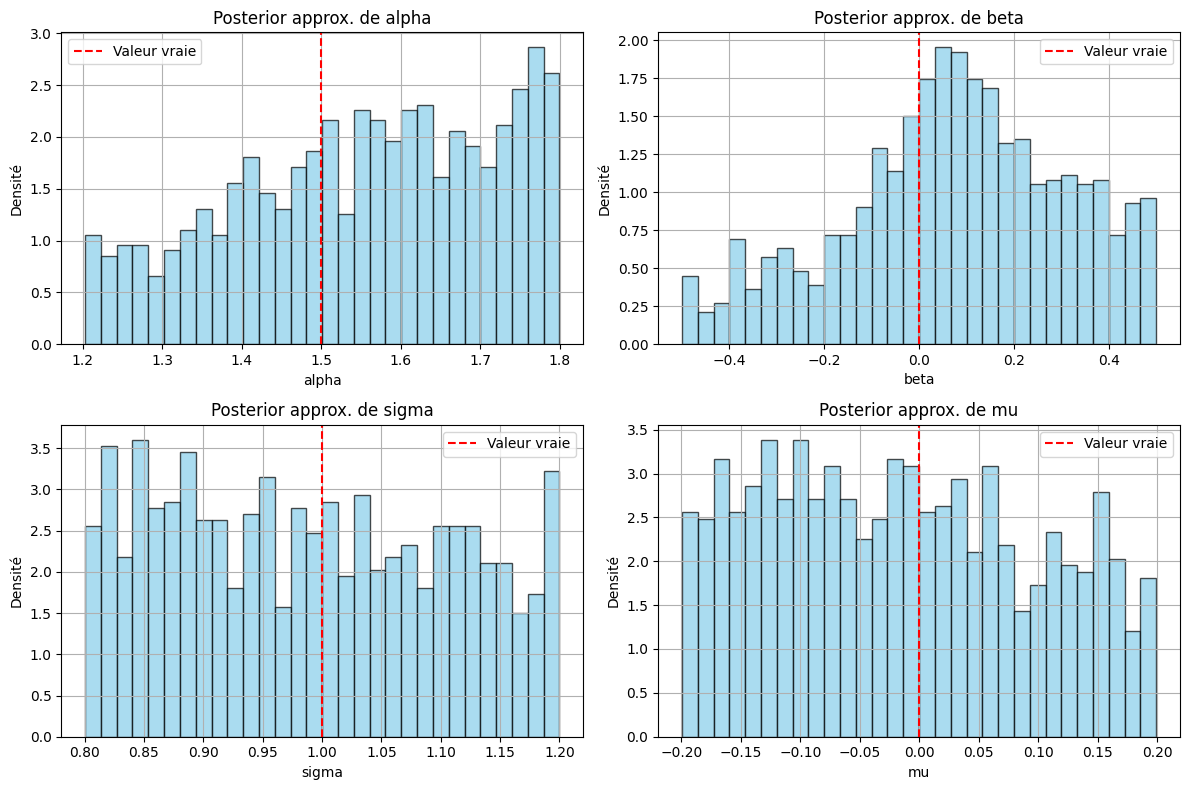

In [23]:


# ---------------------
# ABC rejection
def abc_rejection(x_obs, summary_stat, simulator, prior_sampler, distance, epsilon, n_samples):
    s_obs = summary_stat(x_obs)
    accepted_thetas = []

    while len(accepted_thetas) < n_samples:
        theta = prior_sampler()
        x_sim = simulator(theta)
        s_sim = summary_stat(x_sim)
        if distance(s_obs, s_sim) < epsilon:
            accepted_thetas.append(theta)

    return np.array(accepted_thetas)

# ---------------------
# Lancement
np.random.seed(42)

true_params = (1.5, 0.0, 1.0, 0.0)
x_obs = simulate_data(true_params, size=100)

posterior_samples = abc_rejection(
    x_obs=x_obs,
    summary_stat=summary_stat,
    simulator=lambda theta: simulate_data(theta, size=100),
    prior_sampler=prior_sampler,
    distance=distance,
    epsilon=0.1,
    n_samples=1000
)

# ---------------------
# Tracé des histogrammes
param_names = ['alpha', 'beta', 'sigma', 'mu']
true_vals = true_params

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(posterior_samples[:, i], bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(true_vals[i], color='red', linestyle='--', label='Valeur vraie')
    plt.xlabel(param_names[i])
    plt.ylabel('Densité')
    plt.title(f'Posterior approx. de {param_names[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## MCMC ABC

In [24]:
def mcmc_abc(x_obs, summary_stat, simulator, distance,prior_sampler, proposal_sampler, epsilon, n_samples):
    s_obs = summary_stat(x_obs)
    
    theta_curr = prior_sampler()
    samples = []
    accepted = 0
    total = 0

    while len(samples) < n_samples:
        theta_prop = proposal_sampler(theta_curr)
        x_sim = simulator(theta_prop)
        s_sim = summary_stat(x_sim)
        total += 1

        if distance(s_obs, s_sim) < epsilon:
            theta_curr = theta_prop
            samples.append(theta_curr)
            accepted += 1

    print(f"Taux d'acceptation : {accepted}/{total} = {accepted / total:.3f}")
    return np.array(samples)


In [25]:
def prior_sampler():
    alpha = np.random.uniform(1.2, 1.8)
    beta = np.random.uniform(-0.5, 0.5)
    sigma = np.random.uniform(0.8, 1.2)
    mu = np.random.uniform(-0.2, 0.2)
    return (alpha, beta, sigma, mu)

def proposal_sampler(theta_curr, step_sizes=(0.02, 0.05, 0.02, 0.02)):
    alpha, beta, sigma, mu = theta_curr
    a = np.clip(np.random.normal(alpha, step_sizes[0]), 1.2, 1.8)
    b = np.clip(np.random.normal(beta, step_sizes[1]), -0.5, 0.5)
    s = np.clip(np.random.normal(sigma, step_sizes[2]), 0.8, 1.2)
    m = np.clip(np.random.normal(mu, step_sizes[3]), -0.2, 0.2)
    return (a, b, s, m)


In [26]:
# Données observées
true_params = (1.5, 0.0, 1.0, 0.0)
x_obs = simulate_data(true_params, size=100)

# MCMC-ABC
posterior_mcmc = mcmc_abc(
    x_obs=x_obs,
    summary_stat=summary_stat,
    simulator=lambda theta: simulate_data(theta, size=100),
    distance=distance,
    prior_sampler=prior_sampler,
    proposal_sampler=proposal_sampler,
    epsilon=0.1,
    n_samples=500
)


Taux d'acceptation : 500/1587 = 0.315


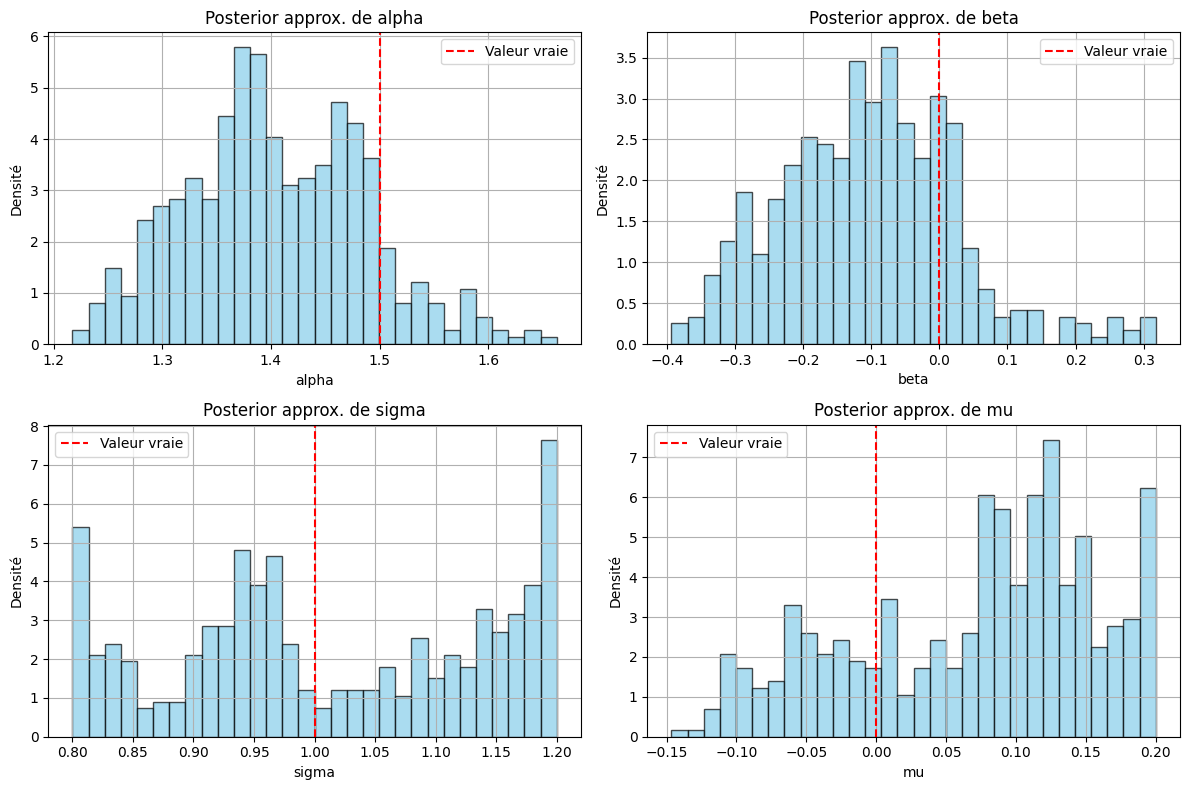

In [27]:

# ---------------------
# Tracé des histogrammes
param_names = ['alpha', 'beta', 'sigma', 'mu']
true_vals = true_params

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(posterior_mcmc[:, i], bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(true_vals[i], color='red', linestyle='--', label='Valeur vraie')
    plt.xlabel(param_names[i])
    plt.ylabel('Densité')
    plt.title(f'Posterior approx. de {param_names[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## SMC-ABC

In [28]:
def smc_abc(
    x_obs, summary_stat, simulator, distance,
    prior_sampler, perturb_fn,
    n_particles=200, n_iterations=5, epsilons=None
):
    s_obs = summary_stat(x_obs)
    particles = []
    weights = []
    distances = []

    if epsilons is None:
        epsilons = np.linspace(1.0, 0.05, n_iterations)

    # Initial population (from prior)
    curr_particles = []
    curr_weights = []
    while len(curr_particles) < n_particles:
        theta = prior_sampler()
        x_sim = simulator(theta)
        s_sim = summary_stat(x_sim)
        if distance(s_obs, s_sim) < epsilons[0]:
            curr_particles.append(theta)
            curr_weights.append(1.0)  # uniform initial weights

    curr_particles = np.array(curr_particles)
    curr_weights = np.array(curr_weights)
    curr_weights /= curr_weights.sum()

    particles.append(curr_particles)
    weights.append(curr_weights)

    for t in range(1, n_iterations):
        next_particles = []
        next_weights = []
        epsilon = epsilons[t]

        print(f"Génération {t}, epsilon = {epsilon:.3f}")

        while len(next_particles) < n_particles:
            idx = np.random.choice(len(curr_particles), p=curr_weights)
            theta_old = curr_particles[idx]
            theta_new = perturb_fn(theta_old)
            x_sim = simulator(theta_new)
            s_sim = summary_stat(x_sim)

            if distance(s_obs, s_sim) < epsilon:
                # Compute weight
                prior_prob = 1.0  # uniforme, donc constante
                denom = np.sum([
                    w * kernel_density(theta_new, theta_j, scale=0.05)
                    for theta_j, w in zip(curr_particles, curr_weights)
                ])
                weight = prior_prob / denom if denom > 0 else 0
                next_particles.append(theta_new)
                next_weights.append(weight)

        curr_particles = np.array(next_particles)
        curr_weights = np.array(next_weights)
        curr_weights /= curr_weights.sum()

        particles.append(curr_particles)
        weights.append(curr_weights)

    return particles[-1], weights[-1]


def kernel_density(theta1, theta2, scale=0.05):
    return np.exp(-np.sum((np.array(theta1) - np.array(theta2))**2) / (2 * scale**2))

def perturb_fn(theta, scale=0.05):
    noise = np.random.normal(0, scale, size=4)
    perturbed = np.clip(np.array(theta) + noise, [1.2, -0.5, 0.8, -0.2], [1.8, 0.5, 1.2, 0.2])
    return tuple(perturbed)


In [29]:
# Données observées
true_params = (1.5, 0.0, 1.0, 0.0)
x_obs = simulate_data(true_params, size=100)

# Exécution SMC-ABC
posterior_smc, weights_smc = smc_abc(
    x_obs=x_obs,
    summary_stat=summary_stat,
    simulator=lambda theta: simulate_data(theta, size=100),
    distance=distance,
    prior_sampler=prior_sampler,
    perturb_fn=perturb_fn,
    n_particles=300,
    n_iterations=5
)


Génération 1, epsilon = 0.762
Génération 2, epsilon = 0.525
Génération 3, epsilon = 0.288
Génération 4, epsilon = 0.050


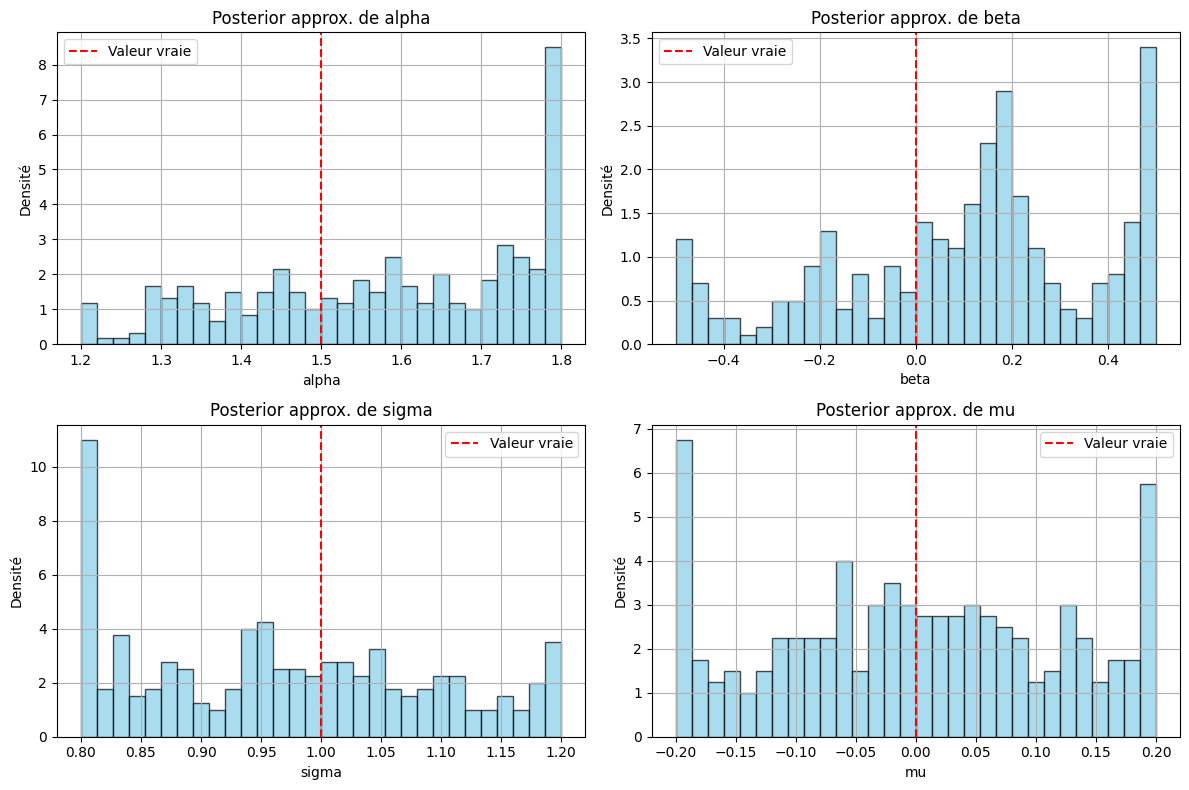

In [30]:

# ---------------------
# Tracé des histogrammes
param_names = ['alpha', 'beta', 'sigma', 'mu']
true_vals = true_params

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(posterior_smc[:, i], bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(true_vals[i], color='red', linestyle='--', label='Valeur vraie')
    plt.xlabel(param_names[i])
    plt.ylabel('Densité')
    plt.title(f'Posterior approx. de {param_names[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()